In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_samples = 2048
do_training = True
do_plotting = True
seed = 42

is_convolutional = True
save_model = False
save_synthetic_samples = False

class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/'


# if is_convolutional:
#     arch_tag = 'convolutional_arch'
#     discriminator = convolutional_discriminator
#     adaptive_training = None
    
# else:
    
#     arch_tag = 'mlp_arch'
#     discriminator = mlp_discriminator
#     adaptive_training = None
    
    
    
    

# experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'
experiment_name = 'test_raw_gan'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [6]:
training_data = PointCloudDataSet(full_pclouds[:1000])
max_epochs = 400
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}

noise_dim = 512
init_lr = 0.0005

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [7]:
leak = 0.2
adaptive_training = 0.8
gen_kwargs = {'b_norm': False,
             'layer_sizes':[64, 128, 256, 512, 1024]
             }


disc_kwargs = { 'encoder_args' : {'n_filters': [128, 128, 256, 512],
                'filter_sizes': [40, 20, 10, 10],
                'strides': [1, 2, 2, 1]},
                'decoder_layer_sizes':[128, 64, 1],
                'non_linearity': leaky_relu(leak)                
              }


generator = point_cloud_generator
discriminator = convolutional_discriminator


# disc_kwargs = {'encoder_args':{'n_filters': [64, 128, 512, 1024], 
#                                'filter_sizes': [1, 1, 1, 1], 
#                                'strides': [1, 1, 1, 1]},

#                'decoder_layer_sizes':[128, 64, 1]               
#               }

# disc_kwargs = {'encoder_args':{'n_filters': [64, 128, 256, 512], 
#                                'filter_sizes': [40, 20, 20, 10], 
#                                'strides': [5, 5, 5, 5]},

#                'decoder_layer_sizes':[128, 64, 1]
#               }

In [ ]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim,
             discriminator, generator, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

In [ ]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        train_stats.append((epoch,) + loss)
        accum_syn_data.append(gan.generate(n_syn_samples, noise_params))

0.6267 0.443094
1 (1.3744821548461914, 0.76817783117294314) 11.5642797947
0.636707 0.479561
2 (1.2817203462123872, 0.91215897053480144) 9.62714600563
0.641015 0.566107
3 (1.1481294244527818, 1.3478553175926209) 9.54576587677
0.703782 0.659801
4 (1.2541427717489355, 1.8024952173233033) 8.97361397743
0.808292 0.718482
5 (0.94591445061895585, 1.5577395260334015) 8.02334690094
0.862391 0.792421
6 (0.58285331726074219, 1.7371585547924042) 7.43725395203
0.80625 0.794027
7 (0.85324689320155556, 2.0469195902347566) 8.51571893692
0.817759 0.79781
8 (0.9231439352035522, 1.8964999794960022) 8.07865190506
0.789276 0.753043
9 (0.88824764490127561, 2.0081305384635924) 9.05350518227
0.917543 0.729205
10 (0.56488408148288727, 1.4697663187980652) 8.36098790169
0.797966 0.835203
11 (0.84591712057590485, 2.1475020885467528) 8.39405798912
0.871963 0.727449
12 (0.71755941377745736, 1.8139533638954162) 9.21818900108
0.864355 0.809688
13 (0.63466281890869136, 1.9991628050804138) 8.16632294655
0.804867 0.7975

In [49]:
epoch_to_check = 
n_check = 10
check_data = accum_syn_data[epoch_to_check-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot()    

IndexError: list index out of range

In [ ]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss)
    plt.plot(x, g_loss)
    plt.title('Raw GAN training. (%s, %s)' % (class_name, arch_tag) )
    plt.legend(['d_loss', 'g_loss'], loc=0)
    plt.xlabel('Epochs.')
    plt.ylabel('Loss.')

In [ ]:
if save_synthetic_samples:    
    save_dir = osp.join(synthetic_data_out_dir, experiment_name)
    create_dir(save_dir)
    epochs_to_save = range(1, 100, 5) # Save every 5 epochs
    for i in epochs_to_save:
        np.savez(osp.join(save_dir, 'epoch_' + str(i)), accum_syn_data[i-1])

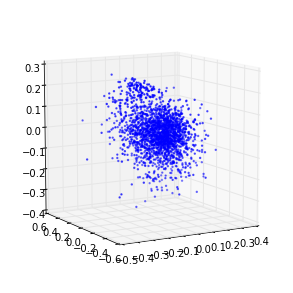

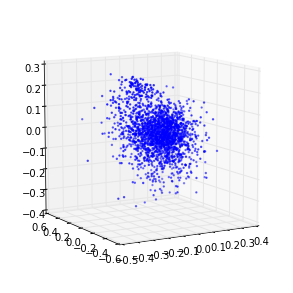

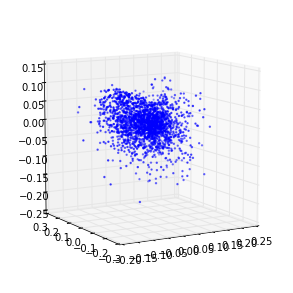

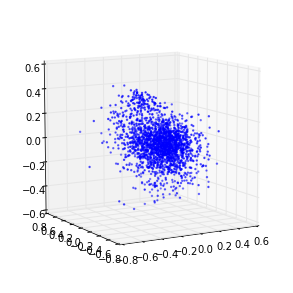

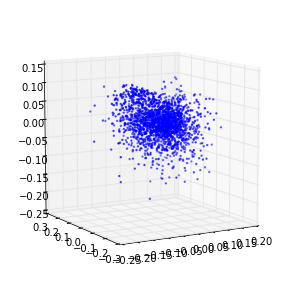

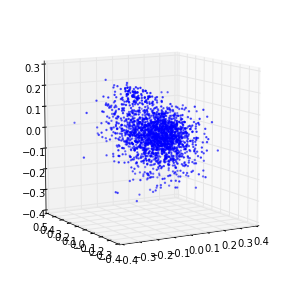

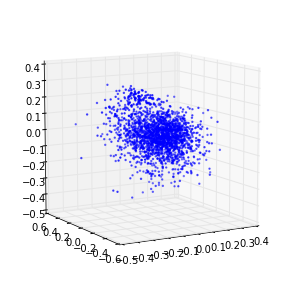

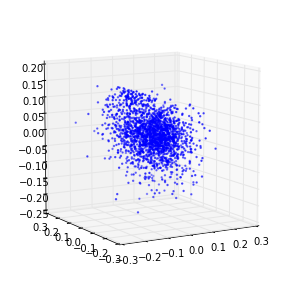

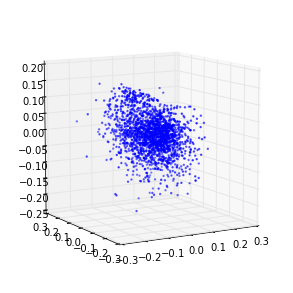

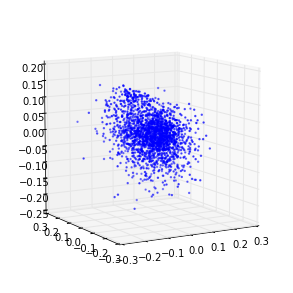